In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, LogitLocator, NullFormatter
from jackknife import *
from scipy.optimize import curve_fit, root_scalar, minimize_scalar
from scipy.integrate import quad, quad_vec, dblquad
from scipy.special import gamma, hyp2f1
from corr_fits import *
from spectral_density import *
import mpmath

mpmath.mp.dps = 15
plt.style.use('my_style.mplstyle')

kernels_mellin = {
    "None": lambda s, w, sigma: np.sqrt(2. * np.pi) * u_s(s, w),
    "Gaussian": lambda s, w, sigma: 2**(-1.25+s*0.5j)*sigma**(-1.5+s*1.0j)*complex(sigma*mpmath.gamma(0.25+s*0.5j)*mpmath.hyp1f1(0.25-s*0.5j, 0.5, -w**2/(2*sigma**2)) + \
                                                                                   np.sqrt(2)*w*mpmath.gamma(0.75+s*0.5j)*mpmath.hyp1f1(0.75-s*0.5j, 1.5, -w**2/(2*sigma**2)))/np.sqrt(np.pi), 
    "Gaussian2": lambda s, w, sigma: np.exp(-w**2.0/(4.0 * sigma ** 2.0)) * complex(mpmath.pcfd(-0.5 - s * 1.0j, - w/sigma) *\
                                                                                      mpmath.gamma(0.5 + s * 1.0j)) * u_s(s, sigma),
    "Tikhonov": lambda s, w, a: np.sqrt(2. * np.pi) * u_s(s, w) * np.abs(gamma(0.5 + s * 1.0j))**2.0 / (np.abs(gamma(0.5 + s * 1.0j))**2.0 + a),
    "Breit-Wigner": lambda s, w, sigma: -np.sqrt(2.*np.pi) * u_s(s, np.sqrt(w**2.0 + sigma**2.0)) * complex(mpmath.sin((-0.5+s*1.0j)*mpmath.acos(-w/mpmath.sqrt(w**2.0 + sigma**2.0)))/\
                                        mpmath.sin((0.5+s*1.0j)*np.pi))
}

def u_s(s:float, w:float) -> complex:
    return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

def mellin_C2(s:np.ndarray, par:np.ndarray, n:float, t_max = +np.inf, num = False):
    if not isinstance(s, (np.ndarray, list)):
        s = np.array([s])
    else:
        s = np.array(s)
    
    r = np.zeros(len(s), dtype=complex)
    J = np.zeros((len(par), len(s)), dtype=complex)
    if num:
        for i in range(len(s)):
            f = lambda t: (par[0]*np.exp(-par[1] * t) + par[2] * np.exp(-par[3] * t)) * (t ** n) * u_s(s[i], t)
            r[i] = quad(f, 0, t_max, complex_func=True)[0]
            f = lambda t, w, n: np.exp(-w * t) * (t ** n) * u_s(s[i], t)
            J[:, i] = np.array([quad(f, 0, t_max, args=(par[1], n), complex_func=True)[0], -par[0] * quad(f, 0, t_max, args=(par[1], n+1), complex_func=True)[0], \
                          quad(f, 0, t_max, args=(par[3], n), complex_func=True)[0], -par[2] * quad(f, 0, t_max, args=(par[3], n+1), complex_func=True)[0]])
    else:
        for i in range(len(s)):
            tr = lambda w, n: complex(mpmath.gammainc(n + 0.5 + s[i] * 1.0j, 0, w * t_max)) * (w ** (-n)) * u_s(s[i], w).conjugate()
            r[i] = par[0] * tr(par[1], n) + par[2] * tr(par[3], n)
            J[:, i] = np.array([tr(par[1], n), -par[0]*tr(par[1], n+1), tr(par[3], n), -par[2]*tr(par[3], n+1)])
    
    if len(s) == 1:
        return r[0], np.reshape(J, (len(par), ))
    return r, J

def modulus(x:np.ndarray[complex], J:np.ndarray[complex], cov:np.ndarray[float] = 0, print_J = False):
    m = np.abs(x)
    if not isinstance(x, (np.ndarray, list)):
        J_mod = (x.real * J.real + x.imag * J.imag)/m
        if print_J:
            return m, J_mod
        else:
            return m, np.sqrt(J_mod.T @ cov @ J_mod)
    else:
        x_ext = np.tile(x, (len(J[:, 0]), 1))
        J_mod = (x_ext.real * J.real + x_ext.imag * J.imag)/np.abs(x_ext)
        if print_J:
            return m, J_mod
        else:
            return m, np.sqrt(np.diag(J_mod.T @ cov @ J_mod))
    
def rho_mellin(w, par, s_max, n, cov_par, t_max = +np.inf, ker = "None", sigma = 0, print_J = False, s_min = 0):
    if not isinstance(w, (np.ndarray, list)):
        w = np.array([w])
    else:
        w = np.array(w)
    
    r = np.zeros(len(w))
    J = np.zeros((len(par), len(w)))
    for i in range(len(w)):
        f = lambda s: (2. * mellin_C2(s, par, n, t_max)[0] * kernels_mellin[ker](s, w[i], sigma) / complex(mpmath.gamma(n + 0.5 + s * 1.0j)) / np.sqrt(2 * np.pi)).real
        r[i] = quad(f, s_min, s_max)[0]
        f = lambda s: np.reshape((np.array(2. * mellin_C2(s, par, n, t_max)[1] * kernels_mellin[ker](s, w[i], sigma) / mpmath.gamma(n + 0.5 + s * 1.0j) / np.sqrt(2 * np.pi), dtype = complex)).real, (len(par),))
        J[:, i] = quad_vec(f, s_min, s_max)[0]

    if len(w) == 1:
        if not print_J:
            return r[0], np.sqrt(np.diagonal(J.T @ cov_par @ J))[0]
        else:
            return r[0], np.reshape(J, (len(par),))
    if not print_J:
        return r, np.sqrt(np.diagonal(J.T @ cov_par @ J))
    else:
        return r, J

def relative_diff(a, b, J_a, J_b, cov_a, cov_b = 0, cov_ab = 0, samepar = True):
    if samepar:
        J = (b * J_a - a * J_b) / (b ** 2.0)
        err = np.sqrt(J.T @ cov_a @ J)
    else:
        err = np.sqrt((J_a.T @ cov_a @ J_a)/(b ** 2.0) + (a ** 2.0) * (J_b.T @ cov_b @ J_b)/(b ** 4.0) - 2 * a * (J_a.T @ cov_ab @ J_b) / (b ** 3.0))
    return np.abs(a/b - 1), err

def bound_mellin(t_max, par, n, cov, print_J = False):
    d = Double_exp_np()
    mod_gamma, J_gamma = float(mpmath.gammainc(n+0.5, par[1]*t_max)), \
                         np.array([-np.exp(-par[1]*t_max) * (par[1] * t_max) ** (n-0.5) * t_max])
    b = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * d.f(t_max, par) * mod_gamma
    
    J_corr = d.jac(t_max, par)
    J = par[1] ** (-n - 0.5) * np.exp(par[1] * t_max) * J_corr * mod_gamma
    J[1] += (t_max - (n+0.5)/par[1] + J_gamma[0] / mod_gamma) * b
    
    if print_J:
        return b/np.sqrt(2 * np.pi), J/np.sqrt(2 * np.pi)
    else: 
        return b/np.sqrt(2 * np.pi), np.sqrt(J.T @ cov @ J)/np.sqrt(2 * np.pi)
    
def s_t_relation(s, t_max, par, cov, n, c_sys, c_stat = 0):
    m, J_m = mellin_C2(s, par, n, t_max)
    if c_stat == 0:
        _, mod = modulus(m, J_m, cov)
        return bound_mellin(t_max, par, n, cov)[0] - c_sys * mod
    else:
        mod, _ = modulus(m, J_m, cov, True)
        return bound_mellin(t_max, par, n, cov)[0] - c_sys * c_stat * mod

def compute_smax(t_max, par, cov, n, c_sys, c_stat, bracket):
    f = lambda x: s_t_relation(x, t_max, par, cov, n, c_sys, c_stat)
    res = root_scalar(f, bracket=bracket)
    return res.root

def bound_mellin_as(t_max, n, par):
    d = Double_exp_np()
    return t_max **(n-0.5) * d.f(t_max, par)/par[1]/np.sqrt(2 * np.pi)

def s_t_relation_as(s, t_max, par, cov, n, c_sys, c_stat = 0):
    m, J_m = mellin_C2(s, par, n, t_max)
    if c_stat == 0:
        _, mod = modulus(m, J_m, cov)
        return bound_mellin_as(t_max, n, par) - c_sys * mod
    else:
        mod, _ = modulus(m, J_m, cov, True)
        return bound_mellin_as(t_max, n, par) - c_sys * c_stat * mod

def compute_smax_as(t_max, par, cov, n, c_sys, c_stat, bracket):
    f = lambda x: s_t_relation_as(x, t_max, par, cov, n, c_sys, c_stat)
    res = root_scalar(f, bracket=bracket)
    return res.root

def sample(t_max, par, cov):
    corr_func = Double_exp()

    times = range(0, int(t_max))
    corr_fit = mpmath.matrix(len(times), 1)
    cov_corr_fit = mpmath.matrix(len(times), len(times))
    for t1 in times:
        corr_fit[t1] = corr_func.f(mpmath.mpf(t1), par)
        for t2 in times:
            cov_corr_fit[t1, t2] = corr_func.cov_matrix(mpmath.mpf(t1), mpmath.mpf(t2), par, cov)

    corr_fit = np.reshape(np.array(corr_fit.tolist(), dtype = float), (len(corr_fit),))
    cov_corr_fit = np.array(cov_corr_fit.tolist(), dtype = float)
    return corr_fit, cov_corr_fit

def bound_t_rho(w, s_max, t_max, n, par, cov, ker = "None", sigma = 0, print_J = False):
    b, J = bound_mellin(t_max, par, n, cov, print_J = True)
    integrand = lambda s: (np.abs(kernels_mellin[ker](s, w, sigma))) /np.abs(gamma(n + 0.5 + s * 1.0j))
    c = np.sqrt(2 /(np.pi)) * quad(integrand, 0, s_max)[0]
    return (b * c, np.sqrt(J.T @ cov @ J) * c)*(not print_J) + (b * c, J * c)*(print_J)

def compute_smax_rho(w, n, t_max, par, cov_par, c_sys, bracket, ker = "None", sigma = 0):
    f = lambda s: rho_mellin(w, par, s, n, cov_par, t_max, ker, sigma)[1] * c_sys - bound_t_rho(w, s, t_max, n, par, cov_par, ker, sigma)[0]
    return root_scalar(f, bracket=bracket).root

def bound_smax(w, s_max, n, par, cov, smearing = "Tikhonov", sigma = 1e-6, t_max = +np.inf, print_J = False):
    K_mell = lambda s: np.abs(kernels_mellin[smearing](s, w, sigma))
    c = quad(K_mell, s_max, +np.inf)[0] / gamma(n + 0.5) * np.sqrt(2. / np.pi)
    mell, J_mell = mellin_C2(0, par, n, t_max)
    if not np.isinf(t_max):
        b, J_b = bound_mellin(t_max, par, n, cov, True)
        mell += b
        J_mell += J_b
    return (not print_J)*(c * mell.real, c * np.sqrt(J_mell.real.T @ cov @ J_mell.real)) + (print_J)*(c*mell.real, c*J_mell.real)

class utility:
    def __init__(self):
        pass

    def write_data(self, data, index_list, file_path, err=False):
        n_index = len(index_list)
        ind_length = np.array([len(i) for i in index_list])
        total_data = np.prod(ind_length)

        f = open(file_path, "w")
        for i in range(len(index_list)):
            print(ind_length[i], end=" ", file = f)
        print("", file = f)
        for i in range(total_data):
            pos = np.zeros(n_index, dtype=int)
            tmp = i
            for n in range(n_index-1, -1, -1):
                pos[n] = tmp % ind_length[n]
                tmp = tmp // ind_length[n]
            
            if pos[-1] == 0:
                for n in range(n_index-1):
                    print(index_list[n][pos[n]], end = " ", file = f)
                print("", file = f)
            if err:
                value = data[tuple(pos)]
                print(index_list[-1][pos[-1]], value[0], value[1], file = f)
            else:
                print(index_list[-1][pos[-1]], data[tuple(pos)], file = f)
        f.close()

    def read_data(self, file_path, err = False, return_ind=False):
        f = open(file_path)
        ind_length = np.array(f.readline().split(), dtype=int)
        n_index = len(ind_length)
        total_data = np.prod(ind_length)

        if err:
            data = np.zeros(tuple(np.append(ind_length, 2)))
        else:
            data = np.zeros(tuple(ind_length))
        
        index_list = []
        for i in range(n_index):
            index_list.append([])

        for i in range(total_data):
            pos = np.zeros(n_index, dtype=int)
            tmp = i
            for n in range(n_index-1, -1, -1):
                pos[n] = tmp % ind_length[n]
                tmp = tmp // ind_length[n]
            
            if pos[-1] == 0:
                line = f.readline().split()
                for l in range(len(line)):
                    index_list[l].append(line[l])
            line = f.readline().split()
            index_list[-1].append(float(line[0]))
            
            if err:
                value = [float(line[1]), float(line[2])]
                data[tuple(pos)] = value
            else: 
                data[tuple(pos)] = float(line[1])
        
        f.close()

        if return_ind:
            return data, tuple(index_list)
        return data
    
utils = utility()

In [27]:
#READING THE FULL CORRELATOR
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

dat = df.readlines()

corr_jack = []

for line in dat:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack

corr_full, err_corr_full, cov_corr_full = Jackknife.to_lists(corr_jack)
        
df.close()
jf.close()

In [28]:
#READING PARAMTERS OF THE FIT
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 8:
        for i in range(4):
            par.append(float(t[1 + 2*i]))
        break
par = np.array(par)

data = open("out/vector/data/fits/cov.txt")
cov = np.zeros((len(par), len(par)))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = float(data.readline().split()[0])
data.close()

In [29]:
#COMPUTATION OF THE EXTRAPOLATION AND THE REMAINDER
d = Double_exp_np()
corr_fit = np.zeros(len(corr_full))
diff_m = np.zeros(len(corr_full))
for i in range(len(corr_full)):
    corr_fit[i] = d.f(i, par)
    diff_m[i] = float(corr_full[i] - corr_fit[i])

J = np.zeros((len(par), len(corr_full)))
for i in range(len(corr_full)):
    J[:, i] = np.array(d.jac(i, par).tolist(), dtype = float).reshape((4,))

cov_corr_fit = (J.T @ cov @ J)
err_corr_fit = np.sqrt(np.diagonal(cov_corr_fit))

cf = Corr_fits(d.f, d.der_list(), par, np.arange(8, 41), corr_full[8:41], cov_corr_full[8:41, 8:41])
Cpd = cf.cov_par_data(cov_corr_full[8:41, :])
cov_or_fit = J.T @ Cpd

diff_cov = (cov_corr_full + cov_corr_fit - 2 * cov_or_fit)
diff_err = np.sqrt(np.diagonal(diff_cov))

In [30]:
par_m = np.array([0.00143562, 0.27899689, 0.00931605, 0.61900488])
cov_m = np.array([[5.70251123e-09, 2.36882975e-07, 6.65745273e-08, 1.50046728e-06],
       [2.36882975e-07, 9.99982555e-06, 2.71486256e-06, 6.13994171e-05],
       [6.65745273e-08, 2.71486256e-06, 8.15964208e-07, 1.81451812e-05],
       [1.50046728e-06, 6.13994171e-05, 1.81451812e-05, 4.05212925e-04]])

# Exact spectral densities

In [31]:
m = 2
ker = ["Breit-Wigner"]
sigma = np.array([0.5, 1.0, 2.0])*270*0.065/197.3
w = np.linspace(1, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(sigma), len(w))), np.zeros((len(ker), len(sigma), len(w)))
for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        for wi in range(len(w)):
            rho[ki, sigi, wi], err_rho[ki, sigi, wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma[sigi])

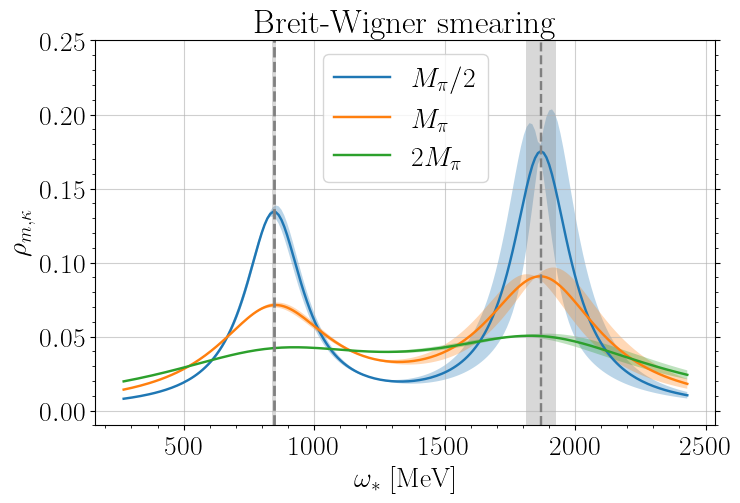

In [32]:
sigma_labels = [r"$M_\pi/2$", r"$M_\pi$", r"$2M_\pi$"]
for ki in range(len(ker)):
    for sigi in range(len(sigma)):
        plt.plot(w/0.065*197.3, rho[ki, sigi, :], label = sigma_labels[sigi])
        plt.fill_between(w/0.065*197.3, rho[ki, sigi, :]-err_rho[ki, sigi, :], rho[ki, sigi, :]+err_rho[ki, sigi, :], alpha = 0.3)
    plt.axvline(par[1]/0.065*197.3, color = "grey", linestyle = "--", alpha = 1, linewidth=2)
    plt.axvspan((par[1] - np.sqrt(cov[1,1]))/0.065*197.3, (par[1] + np.sqrt(cov[1,1]))/0.065*197.3, color = "grey", alpha = 0.3, linewidth=0)
    plt.axvline(par[3]/0.065*197.3, color = "grey", linestyle = "--", alpha = 1)
    plt.axvspan((par[3] - np.sqrt(cov[3,3]))/0.065*197.3, (par[3] + np.sqrt(cov[3,3]))/0.065*197.3, color = "grey", alpha = 0.3, linewidth=0)
    plt.legend()
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\rho_{m, \kappa}$")
    plt.title(ker[ki] + " smearing")
    #plt.tight_layout()
    plt.ylim(-0.01, 0.25)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)
    plt.show()
            

# $\rho(s_\mathrm{max})$

In [33]:
m = 2
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [2.5, 5, 7.5, 10]
w = np.linspace(1, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(s), len(w))), np.zeros((len(ker), len(s), len(w)))
for ki in range(len(ker)):
    for si in range(len(s)):
        for wi in range(len(w)):
            rho[ki, si, wi], err_rho[ki, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, ker=ker[ki], sigma=sigma)

KeyboardInterrupt: 

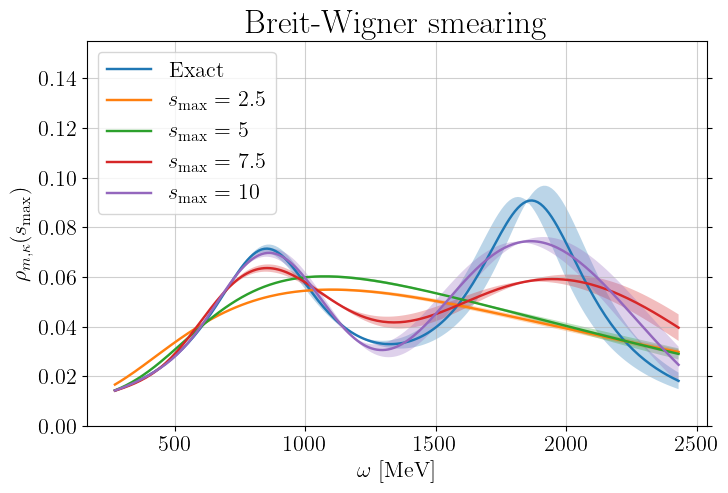

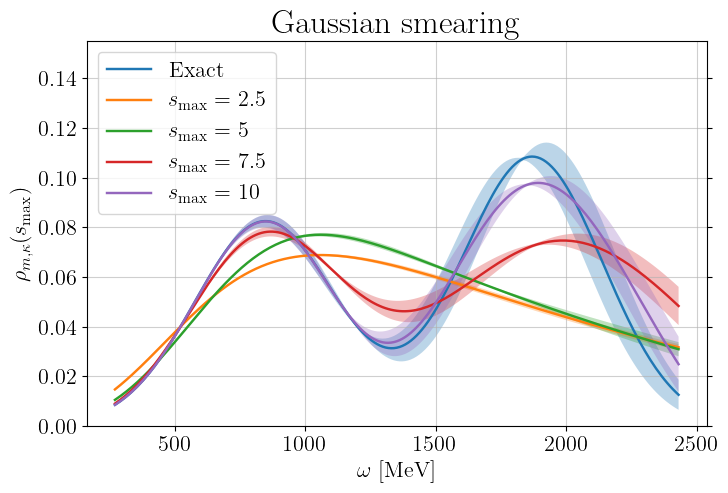

In [46]:
for ki in range(len(ker)):
    ex, err_ex = np.zeros(len(w)), np.zeros(len(w))
    for wi in range(len(w)):
        ex[wi], err_ex[wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)
    plt.plot(w/0.065*197.3, ex, label = r"Exact")
    plt.fill_between(w/0.065*197.3, ex-err_ex, ex+err_ex, alpha = 0.3)
    for si in range(len(s)):
        plt.plot(w/0.065*197.3, rho[ki, si, :], label = r"$s_\mathrm{max} = \,\,$"+r"${}$".format(s[si]))
        plt.fill_between(w/0.065*197.3, rho[ki, si, :]-err_rho[ki, si, :], rho[ki, si, :]+err_rho[ki, si, :], alpha = 0.3)
    plt.legend()
    plt.xlabel(r"$\omega$ [MeV]")
    plt.ylabel(r"$\rho_{m, \kappa}(s_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    b, t = plt.ylim()
    plt.ylim(0, 0.155)
    plt.show()

In [34]:
m = 2
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [+np.inf, 14, 16]
w = np.linspace(1, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(s), len(w))), np.zeros((len(ker), len(s), len(w)))
for ki in range(len(ker)):
    for si in range(len(s)):
        for wi in range(len(w)):
            if s[si] == +np.inf:
                rho[ki, si, wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)[0]
            else:
                rho[ki, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, +np.inf, ker=ker[ki], sigma=sigma)[0]
                err_rho[ki, si, wi] = bound_smax(w[wi], s[si], m, par, cov, ker[ki], sigma, +np.inf)[0]

In [36]:
w = np.linspace(3, 3.3, 201)*270*0.065/197.3

rho_zoom, err_rho_zoom = np.zeros((len(ker), len(s), len(w))), np.zeros((len(ker), len(s), len(w)))
for ki in range(len(ker)):
    for si in range(len(s)):
        for wi in range(len(w)):
            if s[si] == +np.inf:
                rho_zoom[ki, si, wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)[0]
            else:
                rho_zoom[ki, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, +np.inf, ker=ker[ki], sigma=sigma)[0]
                err_rho_zoom[ki, si, wi] = bound_smax(w[wi], s[si], m, par, cov, ker[ki], sigma, +np.inf)[0]

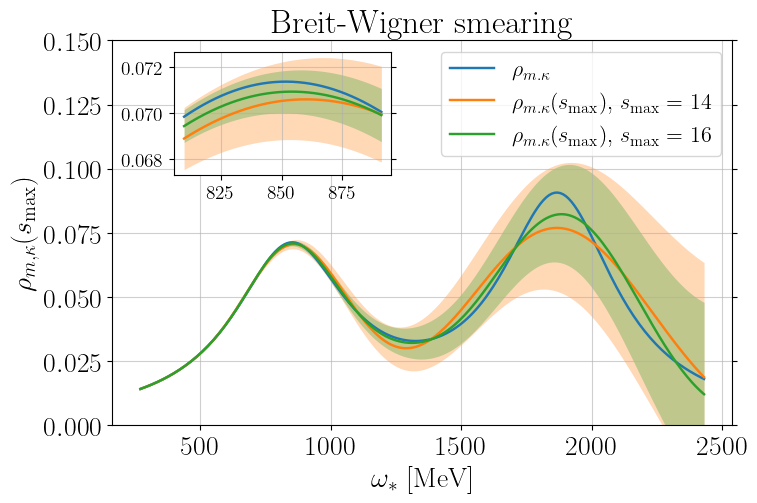

In [45]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    w = np.linspace(1, 9, 201)*270*0.065/197.3
    for si in range(len(s)):
        if s[si] == +np.inf:
            plt.plot(w/0.065*197.3, rho[ki, si, :], label = r"$\rho_{m. \kappa}$")
        else:
            line, = plt.plot(w/0.065*197.3, rho[ki, si, :], label = r"$\rho_{m. \kappa}(s_\mathrm{max})$, $s_\mathrm{max} = \,\,$"+r"${}$".format(s[si]))
            plt.fill_between(w/0.065*197.3, rho[ki, si, :]-err_rho[ki, si, :], rho[ki, si, :]+err_rho[ki, si, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc="upper right", fontsize = 16)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\rho_{m, \kappa}(s_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    plt.ylim(0, 0.15)
    ax = plt.gca()
    ins = ax.inset_axes([0.10, 0.65, 0.35, 0.32])
    w = np.linspace(3, 3.3, 201)*270*0.065/197.3
    for si in range(len(s)):
        if s[si] == +np.inf:
            ins.plot(w/0.065*197.3, rho_zoom[ki, si, :], label = r"$\rho_{m. \kappa}$")
        else:
            line, = ins.plot(w/0.065*197.3, rho_zoom[ki, si, :])
            ins.fill_between(w/0.065*197.3, rho_zoom[ki, si, :]-err_rho_zoom[ki, si, :], rho_zoom[ki, si, :]+err_rho_zoom[ki, si, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    #ins.set_ylim(0.067, 0.073)
    plt.show()

# $\hat\rho(s_\mathrm{max})$

In [46]:
m = 2
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [10]
tmax = [+np.inf, 50, 55]
w = np.linspace(1, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(tmax), len(s), len(w))), np.zeros((len(ker), len(s), len(tmax), len(w)))
for ki in range(len(ker)):
    for ti in range(len(tmax)):
        for si in range(len(s)):
            for wi in range(len(w)):
                rho[ki, ti, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, tmax[ti], ker=ker[ki], sigma=sigma)[0]
        if tmax[ti] != +np.inf:
            for si in range(len(s)):
                for wi in range(len(w)):
                    err_rho[ki, si, ti, wi] = bound_t_rho(w[wi], s[si], tmax[ti], m, par, cov, ker[ki], sigma)[0]
            

In [47]:
m = 2
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
s = [10]
tmax = [+np.inf, 50, 55]
w = np.linspace(3, 3.3, 201)*270*0.065/197.3

rho_zoom, err_rho_zoom = np.zeros((len(ker), len(tmax), len(s), len(w))), np.zeros((len(ker), len(s), len(tmax), len(w)))
for ki in range(len(ker)):
    for ti in range(len(tmax)):
        for si in range(len(s)):
            for wi in range(len(w)):
                rho_zoom[ki, ti, si, wi] = rho_mellin(w[wi], par, s[si], m, cov, tmax[ti], ker=ker[ki], sigma=sigma)[0]
        if tmax[ti] != +np.inf:
            for si in range(len(s)):
                for wi in range(len(w)):
                    err_rho_zoom[ki, si, ti, wi] = bound_t_rho(w[wi], s[si], tmax[ti], m, par, cov, ker[ki], sigma)[0]
            

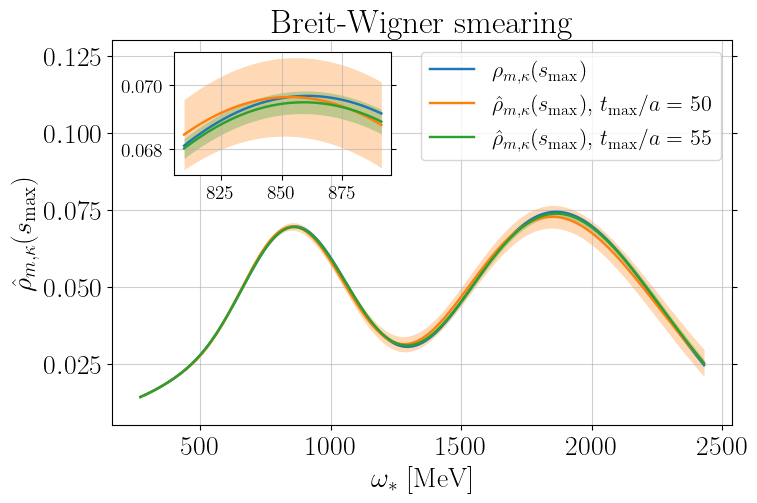

In [50]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8, 7))
    w = np.linspace(1, 9, 201)*270*0.065/197.3
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == +np.inf:
                plt.plot(w/0.065*197.3, rho[ki, ti, si, :], label = r"$\rho_{m, \kappa}(s_\mathrm{max})$")
            else:
                line, = plt.plot(w/0.065*197.3, rho[ki, ti, si, :], label = r"$\hat\rho_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
                plt.fill_between(w/0.065*197.3, rho[ki, ti, si, :]-err_rho[ki, si, ti, :], rho[ki, ti, si, :]+err_rho[ki, si, ti, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    plt.ylim(0.005, 0.13)

    ax = plt.gca()
    w = np.linspace(3, 3.3, 201)*270*0.065/197.3
    ins = ax.inset_axes([0.10, 0.65, 0.35, 0.32])
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == +np.inf:
                ins.plot(w/0.065*197.3, rho_zoom[ki, ti, si, :], label = r"$\rho_{m. \kappa}(s_\mathrm{max})$")
            else:
                line, = ins.plot(w/0.065*197.3, rho_zoom[ki, ti, si, :], label = r"$\hat\rho_{m. \kappa}(s_\mathrm{max})$")
                ins.fill_between(w/0.065*197.3, rho_zoom[ki, ti, si, :]-err_rho_zoom[ki, si, ti, :], rho_zoom[ki, ti, si, :]+err_rho_zoom[ki, si, ti, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

In [9]:
rho, indices = utils.read_data("rho_hat_thesis.txt", return_ind=True)
err_rho = utils.read_data("delta_rho_hat_thesis.txt")
rho_zoom = utils.read_data("rho_hat_thesis_zoom.txt")
err_rho_zoom = utils.read_data("delta_rho_hat_thesis_zoom.txt")

print(indices)

(['Breit-Wigner', 'Breit-Wigner', 'Breit-Wigner', 'Gaussian', 'Gaussian', 'Gaussian'], ['0.1', '0.1', '0.1', '0.1', '0.1', '0.1'], ['10', '10', '10', '10', '10', '10'], ['50', '55', '200', '50', '55', '200'], [0.0, 0.003, 0.006, 0.009, 0.012, 0.015, 0.018, 0.021, 0.024, 0.027, 0.03, 0.033, 0.036, 0.039, 0.042, 0.045, 0.048, 0.051000000000000004, 0.054, 0.056999999999999995, 0.06, 0.063, 0.066, 0.069, 0.072, 0.075, 0.078, 0.081, 0.084, 0.087, 0.09, 0.093, 0.096, 0.099, 0.10200000000000001, 0.10500000000000001, 0.108, 0.111, 0.11399999999999999, 0.11699999999999999, 0.12, 0.123, 0.126, 0.129, 0.132, 0.135, 0.138, 0.14100000000000001, 0.144, 0.147, 0.15, 0.153, 0.156, 0.159, 0.162, 0.165, 0.168, 0.171, 0.174, 0.177, 0.18, 0.183, 0.186, 0.189, 0.192, 0.195, 0.198, 0.201, 0.20400000000000001, 0.20700000000000002, 0.21000000000000002, 0.213, 0.216, 0.219, 0.222, 0.22499999999999998, 0.22799999999999998, 0.23099999999999998, 0.23399999999999999, 0.237, 0.24, 0.243, 0.246, 0.249, 0.252, 0.255,

In [14]:
rho[0, 0, 0, 2, :], rho[1, 0, 0, 2, :]

(array([0.31809687, 0.32390155, 0.32986025, 0.33597822, 0.34226093,
        0.34871407, 0.35534355, 0.36215555, 0.36915649, 0.37635306,
        0.38375226, 0.39136138, 0.39918803, 0.40724018, 0.41552616,
        0.42405471, 0.43283498, 0.44187657, 0.45118956, 0.46078449,
        0.47067242, 0.4808649 , 0.49137395, 0.50221203, 0.51339203,
        0.52492716, 0.53683092, 0.549117  , 0.56179919, 0.57489134,
        0.5884073 , 0.60236086, 0.61676584, 0.63163609, 0.64698571,
        0.66282913, 0.6791815 , 0.69605891, 0.71347887, 0.73146063,
        0.75002574, 0.76919841, 0.78900604, 0.80947955, 0.83065374,
        0.85256752, 0.87526404, 0.89879064, 0.92319871, 0.94854338,
        0.97488293, 1.00227822, 1.03079178, 1.06048688, 1.09142635,
        1.1236714 , 1.15728026, 1.19230682, 1.22879918, 1.26679827,
        1.30633643, 1.34743612, 1.39010866, 1.4343531 , 1.48015528,
        1.52748696, 1.57630522, 1.62655196, 1.67815368, 1.73102141,
        1.78505083, 1.84012266, 1.89610317, 1.95

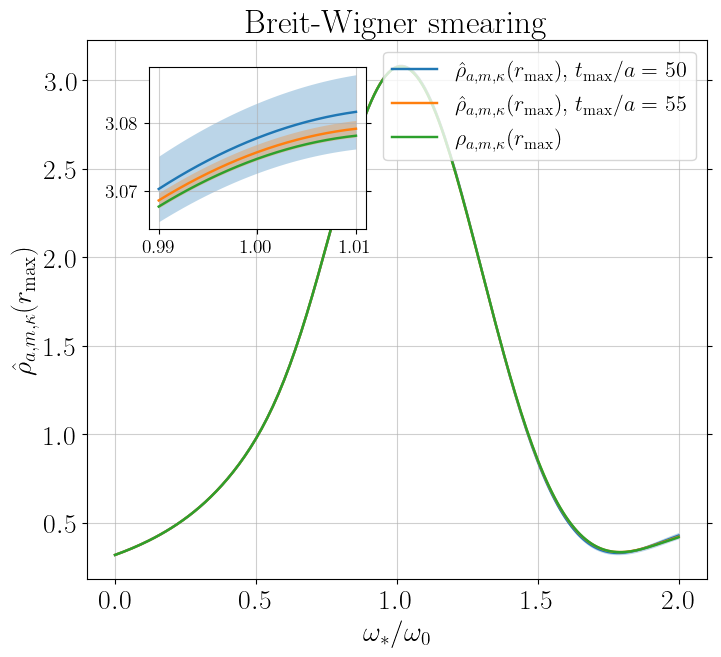

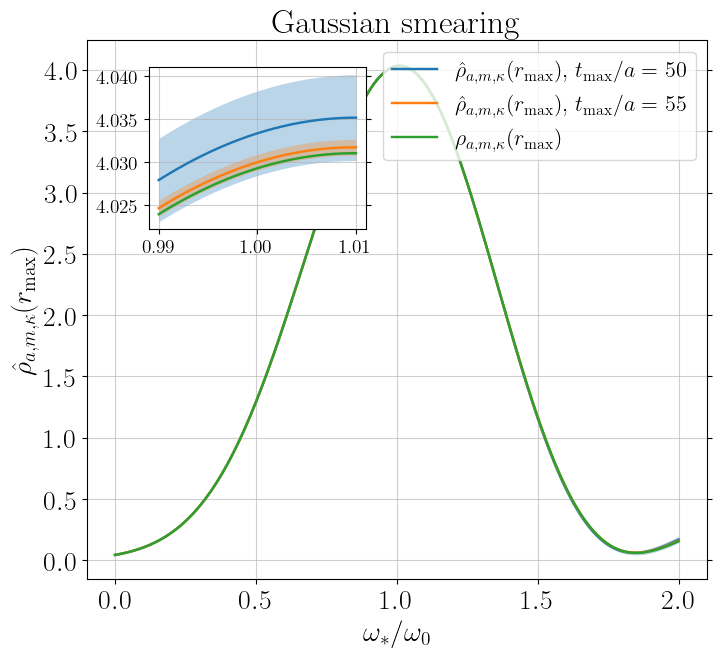

In [22]:
ker = ["Breit-Wigner", "Gaussian"]
s = [10]
tmax = [50, 55, 200]

for ki in range(len(ker)):
    plt.figure(figsize=(8, 7))
    w = np.linspace(0, 2, 201)*0.3
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == 200:
                plt.plot(w/0.3, rho[ki, 0, si, ti, :], label = r"$\rho_{a, m, \kappa}(r_\mathrm{max})$")
            else:
                line, = plt.plot(w/0.3, rho[ki, 0, si, ti, :], label = r"$\hat\rho_{a, m, \kappa}(r_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
                plt.fill_between(w/0.3, rho[ki, 0, si, ti, :]-err_rho[ki, 0, si, ti, :], rho[ki, 0, si, ti, :]+err_rho[ki, 0, si, ti, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel(r"$\omega_*/\omega_0$")
    plt.ylabel(r"$\hat{\rho}_{a, m, \kappa}(r_\mathrm{max})$")
    plt.title(ker[ki] + " smearing", fontsize = 24)
    #plt.tight_layout()
    #b, t = plt.ylim()
    #plt.ylim(0.005, 0.135)

    ax = plt.gca()
    w = np.linspace(0.99, 1.01, 201)
    ins = ax.inset_axes([0.1, 0.65, 0.35, 0.3])
    for si in range(len(s)):
        for ti in range(len(tmax)):
            if tmax[ti] == 200:
                ins.plot(w, rho_zoom[ki, 0, si, ti, :], label = r"$\rho_{m. \kappa}(s_\mathrm{max})$")
            else:
                line, = ins.plot(w, rho_zoom[ki, 0, si, ti, :], label = r"$\hat\rho_{m. \kappa}(s_\mathrm{max})$")
                ins.fill_between(w, rho_zoom[ki, 0, si, ti, :]-err_rho_zoom[ki, 0, si, ti, :], rho_zoom[ki, 0, si, ti, :]+err_rho_zoom[ki, 0, si, ti, :], alpha = 0.3, color = line.get_color(), linewidth=0)
    ins.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

# Optimal $s_\mathrm{max}$

In [51]:
tmax = [47, 95]
brackets = [[9, 10], [15, 20]]
m = 2
ker = ["Breit-Wigner"]
sigma = 270*0.065/197.3
w = np.linspace(1, 9, 201)*270*0.065/197.3

def f(x, w, tmax, m, par, cov, ker, sigma):
    r, er = rho_mellin(w, par, x, m, cov, tmax, ker=ker, sigma=sigma)
    return bound_t_rho(w, x, tmax, m, par, cov, ker, sigma)[0] + bound_smax(w, x, m, par, cov, ker, sigma, tmax)[0] + er

smax = np.zeros((len(ker), len(tmax), len(w)))
for ki in range(len(ker)):
    for ti in range(len(tmax)):
        for wi in range(len(w)):
            print(ker[ki], tmax[ti], w[wi]/0.065*197.3)
            f_wrap = lambda x: f(x, w[wi], tmax[ti], m, par, cov, ker[ki], sigma)
            #for si in np.linspace(10, 20, 10):
            #    print(f_wrap(si))
            smax[ki, ti, wi] = minimize_scalar(f_wrap, bracket=brackets[ti]).x
        

Breit-Wigner 47 270.0
Breit-Wigner 47 280.80000000000007
Breit-Wigner 47 291.6
Breit-Wigner 47 302.40000000000003
Breit-Wigner 47 313.2
Breit-Wigner 47 324.0
Breit-Wigner 47 334.8
Breit-Wigner 47 345.6
Breit-Wigner 47 356.40000000000003
Breit-Wigner 47 367.19999999999993
Breit-Wigner 47 377.99999999999994
Breit-Wigner 47 388.8
Breit-Wigner 47 399.6000000000001
Breit-Wigner 47 410.3999999999999
Breit-Wigner 47 421.2
Breit-Wigner 47 431.99999999999994
Breit-Wigner 47 442.8
Breit-Wigner 47 453.59999999999997
Breit-Wigner 47 464.4
Breit-Wigner 47 475.20000000000005
Breit-Wigner 47 486.0
Breit-Wigner 47 496.8
Breit-Wigner 47 507.59999999999997
Breit-Wigner 47 518.4
Breit-Wigner 47 529.1999999999999
Breit-Wigner 47 540.0
Breit-Wigner 47 550.8
Breit-Wigner 47 561.6000000000001
Breit-Wigner 47 572.4
Breit-Wigner 47 583.2
Breit-Wigner 47 594.0
Breit-Wigner 47 604.8000000000001
Breit-Wigner 47 615.6
Breit-Wigner 47 626.4000000000001
Breit-Wigner 47 637.2000000000002
Breit-Wigner 47 648.000000000

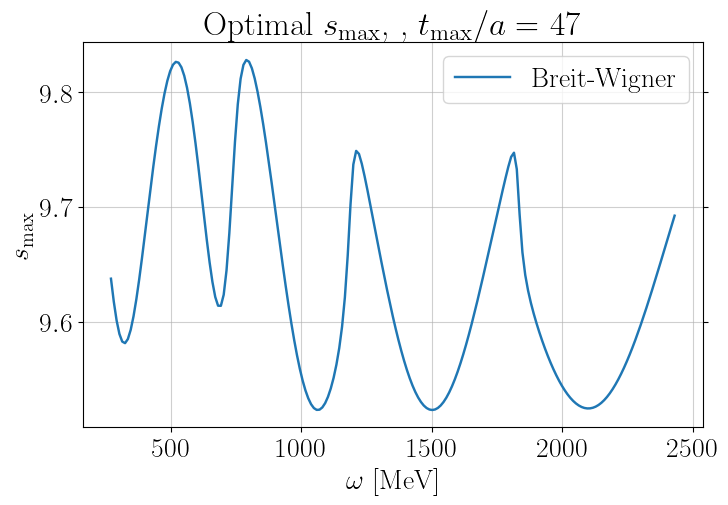

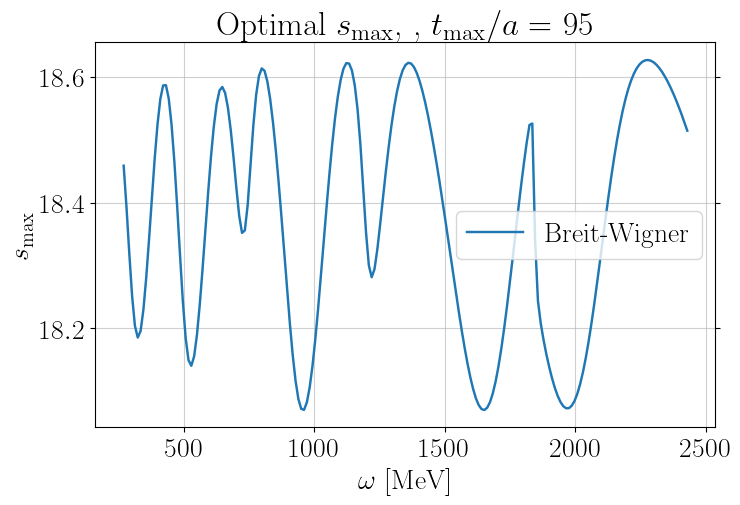

In [53]:
for ti in range(len(tmax)):
    plt.plot(w/0.065*197.3, smax[0, ti, :], label = r"Breit-Wigner")
    plt.xlabel(r"$\omega$ [MeV]")
    plt.ylabel(r"$s_\mathrm{max}$")
    plt.legend()
    plt.title(r"Optimal $s_\mathrm{max}$, , $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
    plt.show()

In [54]:
rho, err_rho = np.zeros((len(ker), len(tmax), len(w))), np.zeros((len(ker), len(tmax), len(w)))
for ki in range(len(ker)):
    print(ker[ki])
    for ti in range(len(tmax)):
        for wi in range(len(w)):
            rho[ki, ti, wi] , stat = rho_mellin(w[wi], par, smax[ki, ti, wi], m, cov, tmax[ti], ker=ker[ki], sigma=sigma)
            sys = bound_t_rho(w[wi], smax[ki, ti, wi], tmax[ti], m, par, cov, ker[ki], sigma)[0] + bound_smax(w[wi], smax[ki, ti, wi], m, par, cov, ker[ki], sigma, tmax[ti])[0]
            err_rho[ki, ti, wi] = np.sqrt(stat**2.0 + sys**2.0)

Breit-Wigner


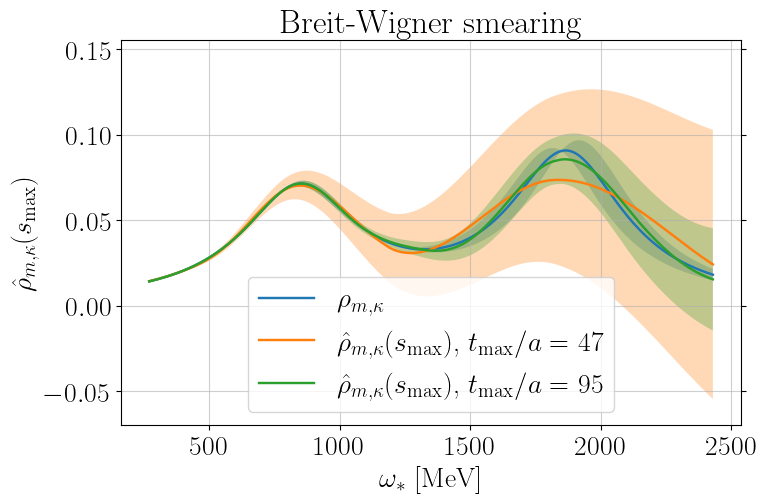

In [55]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    ex, err_ex = np.zeros(len(w)), np.zeros(len(w))
    for wi in range(len(w)):
        ex[wi], err_ex[wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma)
    plt.plot(w/0.065*197.3, ex, label = r"$\rho_{m, \kappa}$")
    plt.fill_between(w/0.065*197.3, ex-err_ex, ex+err_ex, alpha = 0.3)
    for ti in range(len(tmax)):
        plt.plot(w/0.065*197.3, rho[ki, ti, :], label = r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
        plt.fill_between(w/0.065*197.3, rho[ki, ti, :] - err_rho[ki, ti, :], rho[ki, ti, :] + err_rho[ki, ti, :], alpha = 0.3)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.legend()
    plt.title(ker[ki] + " smearing")
    plt.ylim(-0.07, 0.155)
    plt.show()

In [24]:
tmax = [47, 95]
s = [9, 18]
m = 2
ker = ["Breit-Wigner"]
sigma = np.linspace(0.5, 2.5, 201)*270*0.065/197.3
w = np.linspace(1, 9, 201)*270*0.065/197.3

rho, err_rho = np.zeros((len(ker), len(tmax), len(w))), np.zeros((len(ker), len(tmax), len(w)))
for ki in range(len(ker)):
    print(ker[ki])
    for ti in range(len(tmax)):
        for wi in range(len(w)):
            rho[ki, ti, wi] , stat = rho_mellin(w[wi], par, s[ti], m, cov, tmax[ti], ker=ker[ki], sigma=sigma[wi])
            sys = bound_t_rho(w[wi], s[ti], tmax[ti], m, par, cov, ker[ki], sigma[wi])[0] + bound_smax(w[wi], s[ti], m, par, cov, ker[ki], sigma[wi], tmax[ti])[0]
            err_rho[ki, ti, wi] = stat + sys

Breit-Wigner


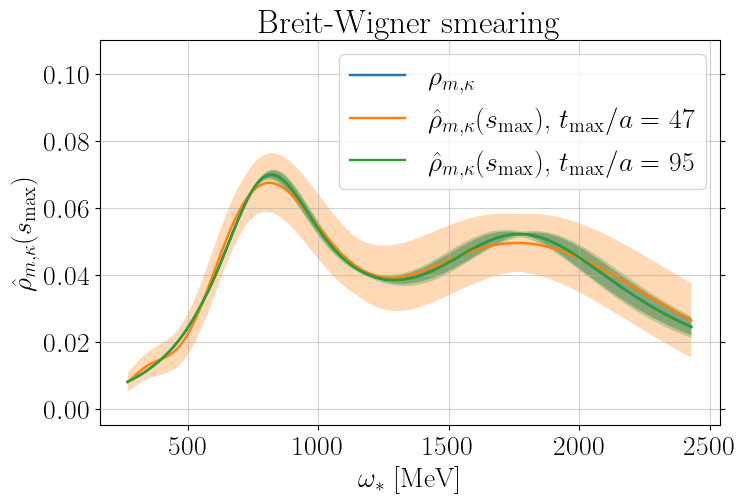

In [25]:
for ki in range(len(ker)):
    #plt.figure(figsize=(8,7))
    ex, err_ex = np.zeros(len(w)), np.zeros(len(w))
    for wi in range(len(w)):
        ex[wi], err_ex[wi] = SD_2exp.rho(w[wi], m, par, cov, ker[ki], sigma[wi])
    plt.plot(w/0.065*197.3, ex, label = r"$\rho_{m, \kappa}$")
    plt.fill_between(w/0.065*197.3, ex-err_ex, ex+err_ex, alpha = 0.5)
    for ti in range(len(tmax)):
        plt.plot(w/0.065*197.3, rho[ki, ti, :], label = r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$, $t_\mathrm{max}/a = \,\,$"+r"${}$".format(tmax[ti]))
        plt.fill_between(w/0.065*197.3, rho[ki, ti, :] - err_rho[ki, ti, :], rho[ki, ti, :] + err_rho[ki, ti, :], alpha = 0.3)
    plt.xlabel(r"$\omega_*$ [MeV]")
    plt.ylabel(r"$\hat{\rho}_{m, \kappa}(s_\mathrm{max})$")
    plt.legend()
    plt.title(ker[ki] + " smearing")
    plt.ylim(-0.005, 0.11)
    plt.show()